In [1]:
#
# Chapter 9, Example 2b
#

import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers, models
import pylab

import os
if not os.path.isdir('figures'):
    print('creating the figures folder')
    os.makedirs('figures')

In [2]:
n_in = 1
n_hidden = 12
n_out = 1
n_steps = 8
n_seqs = 1
sequence_length = 256

n_iters = 2000
lr = 0.001

seed = 10
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.backend.set_floatx('float32')

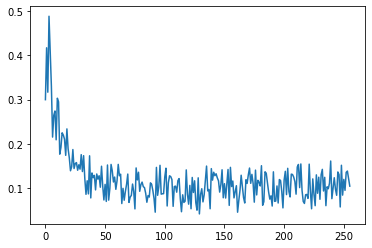

In [3]:
# generate training data
seq = []
for _ in range(n_steps):
    seq.append(random.uniform(0,1))
for _ in range(sequence_length):
    seq.append(0.4*seq[-1]*seq[-3] + 0.2*seq[-5] + 0.3*seq[-7] + 0.1*np.random.random())

    
pylab.figure()
pylab.plot(range(len(seq[n_steps:])), seq[n_steps:])
pylab.savefig('./figures/9.2b_1.png')


x_train, y_train = [], []
for i in range(len(seq) - n_steps - 1):
    x_train.append(np.expand_dims(seq[i:i+n_steps], axis=1).tolist())
    y_train.append(np.expand_dims(seq[i+1:i+n_steps+1], axis=1).tolist())
    
x_train = tf.constant(x_train, dtype=tf.float32)
y_train = tf.constant(y_train, dtype=tf.float32)

In [4]:
class SeriesPredictor(Model):

    def __init__(self, input_dim, seq_size, num_steps, hidden_dim=10, cell_type='lstm', cell_num=2):
        super(SeriesPredictor, self).__init__()
        # Hyperparameters
        self.input_dim = input_dim
        self.seq_size = seq_size
        self.hidden_dim = hidden_dim
        self.num_steps = num_steps
        self.cell_num = cell_num

        # Weight variables and RNN cell
        self.W_out = tf.Variable(tf.keras.backend.random_normal([hidden_dim, 1]))
        self.b_out = tf.Variable(tf.keras.backend.random_normal([1]))
        if cell_type == 'rnn':
            cell_fn = tf.keras.layers.SimpleRNNCell
        elif cell_type == 'gru':
            cell_fn = tf.keras.layers.GRUCell
        elif cell_type == 'lstm':
            cell_fn = tf.keras.layers.LSTMCell
        
        cells = []
        for i in range(cell_num):
            cells.append(cell_fn(self.hidden_dim))
        cells = tf.keras.layers.StackedRNNCells(cells)

        self.rnn = tf.keras.layers.RNN(
            cells,
            return_sequences=True)

    def call(self, x):
        # forward logic
        outputs = self.rnn(x)
        
        out_ = []
        for i, h in enumerate(tf.split(outputs, self.num_steps, axis = 1, num=1)):
            y_ = tf.matmul(tf.squeeze(h, axis=1), self.W_out) + self.b_out
            out_.append(y_)
        
        out = tf.stack(out_, axis=1)
        return out

In [5]:
# Set an optimizer and loss function for training
optimizer = tf.optimizers.Adam(lr=0.001)
def get_loss(output, target):
    mse_loss = tf.reduce_mean(tf.square(output - target))
    return mse_loss

# Training function
def train_step(model, x, target):
    with tf.GradientTape() as tape:
        out = model(x)
        mse_loss = get_loss(out, target)
        gradients = tape.gradient(mse_loss, model.variables)
        gradient_variables = zip(gradients, model.variables)
        optimizer.apply_gradients(gradient_variables)
    return mse_loss

In [6]:
cell_type = 'lstm'
predictor = SeriesPredictor(
    input_dim=n_in,
    seq_size=n_seqs,
    num_steps=n_steps,
    hidden_dim=n_hidden,
    cell_type=cell_type)
loss = []
for i in range(n_iters):

    l = train_step(predictor, x_train, y_train)
    loss.append(l)

    if not i % 100:
        print('iter:%d, cost: %g'%(i, loss[i]))

iter:0, cost: 0.0111745
iter:100, cost: 0.00411208
iter:200, cost: 0.00348006
iter:300, cost: 0.00316266
iter:400, cost: 0.00285052
iter:500, cost: 0.00264288
iter:600, cost: 0.00254518
iter:700, cost: 0.00242942
iter:800, cost: 0.00235113
iter:900, cost: 0.00229962
iter:1000, cost: 0.00224507
iter:1100, cost: 0.00218404
iter:1200, cost: 0.00211843
iter:1300, cost: 0.00206022
iter:1400, cost: 0.00201442
iter:1500, cost: 0.00197847
iter:1600, cost: 0.00194952
iter:1700, cost: 0.00193094
iter:1800, cost: 0.00190117
iter:1900, cost: 0.00187948


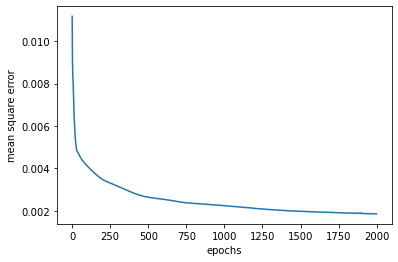

In [7]:
pylab.figure()
pylab.plot(range(n_iters), loss)
pylab.xlabel('epochs')
pylab.ylabel('mean square error')
pylab.savefig('./figures/9.2b_2.png')

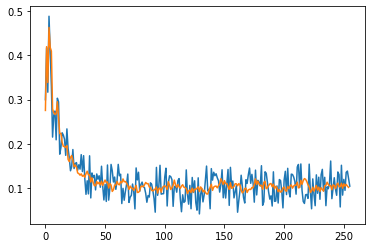

In [8]:
pred = []
for i in range(len(x_train)):
    pred_ = predictor(x_train[i:i+1])
    pred.append(pred_[0, n_steps-1])
    
pylab.figure()
pylab.plot(range(len(seq[n_steps:])), seq[n_steps:])
pylab.plot(range(len(pred)), pred)
pylab.savefig('./figures/9.2b_3.png')

pylab.show()